In [8]:
file_path = ...

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import wiener, get_window
from scipy.signal import butter, filtfilt



fs,xx = wavfile.read(file_path)
if np.shape(np.shape(xx))[0] == 2:
    xx = xx[:,0]
ss = xx - np.mean(xx)

tt = np.arange(len(xx)) / fs
cal = 10**(27/20)  # unit is equiv 27 dB re 1 Pa
ss = cal * ss

print(fs)

96000


In [9]:
ss = wiener(ss,mysize = 10)

In [10]:
#réduire l'enregistrement 
ss = ss[45*fs:60*fs]
tt = tt[45*fs:60*fs]

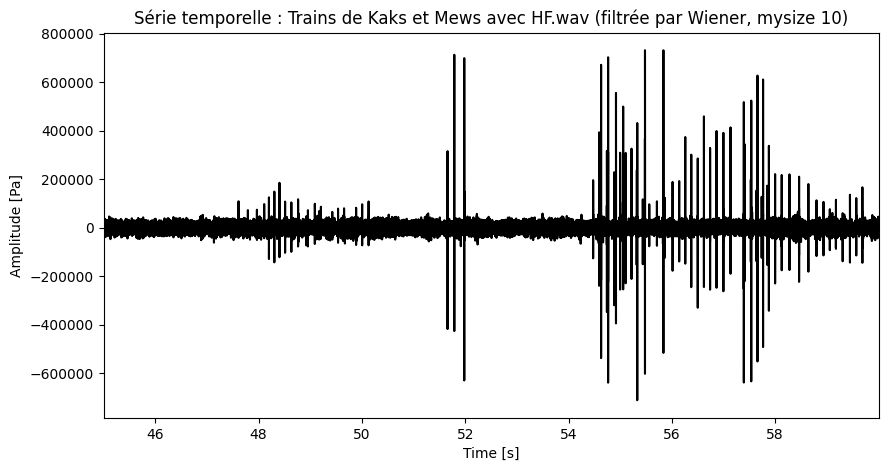

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import wiener, get_window
from scipy.signal import butter, filtfilt

plt.figure(figsize=(10, 5))
plt.plot(tt, ss, 'k')
plt.xlabel('Time [s]')
plt.title("Série temporelle : Trains de Kaks et Mews avec HF.wav (filtrée par Wiener, mysize 10)")
plt.ylabel('Amplitude [Pa]')
plt.xlim([tt[0], tt[-1]])
plt.show()

In [12]:
# Simple Detection Function
def do_simple_detection(snr, tt, th, dt_max):
    # Thresholding
    ith = np.where(snr > th)[0]
    
    # Detection pruning
    jth = ith.copy()
    jj = 0

    for ii in range(1, len(ith)):
        ki = ith[ii]
        kj = ith[jj]

        if tt[ki] - tt[kj] > dt_max:
            jj = ii
            continue
        elif snr[ki] > snr[kj]:
            jth[jj] = 0
            jj = ii
        else:
            jth[ii] = 0

    # Reduce detection vector
    jth = jth[jth != 0]
    
    return jth, ith

In [32]:
# Signal Processing and Click Detection
# Noise estimate over complete time series
nn = np.sqrt(np.mean(ss**2))

# Estimate signal-to-noise ratio
snr = np.abs(ss) / nn

# Set threshold
th = 6

# Set detection pruning window
dt_max = 1 / 1000  # 2 ms

# Simple click detector
jth, ith = do_simple_detection(snr, tt, th, dt_max)

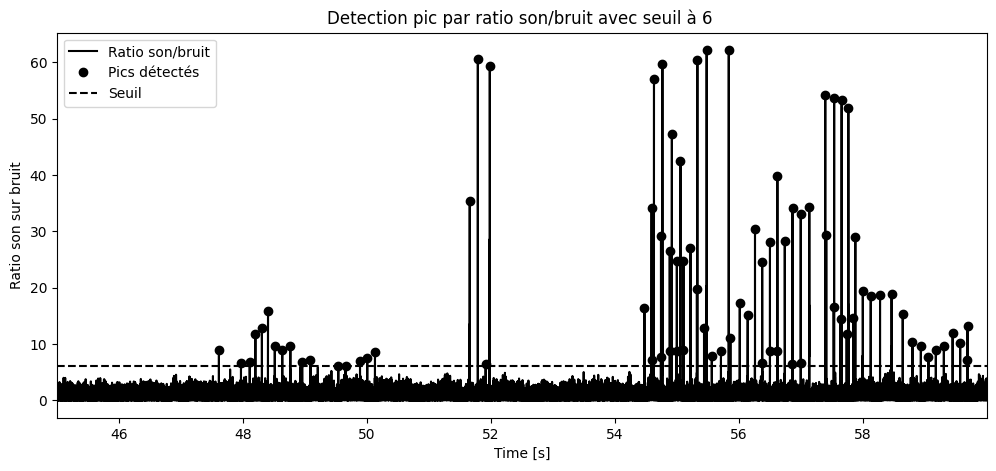

In [33]:
# Plot Results
plt.figure(figsize=(12, 5))
plt.plot(tt, snr, 'k', label='Ratio son/bruit')
plt.plot(tt[jth], snr[jth], 'ko', label='Pics détectés')
plt.plot([tt[0], tt[-1]], [th, th], 'k--', label='Seuil')
plt.xlabel('Time [s]')
plt.title('Detection pic par ratio son/bruit avec seuil à 6 ')
plt.ylabel('Ratio son sur bruit')
plt.xlim([tt[0], tt[-1]])
plt.legend()
plt.show()

In [34]:
import numpy as np

def do_simple_detection_0(snr, tt, th, dt_max):
    ith = np.where(snr > th)[0]
    
    jth = ith.copy()
    jj = 0

    for ii in range(1, len(ith)):
        ki = ith[ii]
        kj = ith[jj]

        if tt[ki] - tt[kj] > dt_max:
            jj = ii
            continue
        elif snr[ki] > snr[kj]:
            jth[jj] = 0
            jj = ii
        else:
            jth[ii] = 0

    jth = jth[jth != 0]
    
    return jth, ith



def do_simple_detection_1(snr, tt, th, dt_max):
    jth, ith = do_simple_detection_0(snr, tt, th, dt_max)
    
    j1 = np.zeros_like(jth)
    j2 = np.zeros_like(jth)

    for ii in range(len(jth)):
        thc = np.where(np.abs(tt[jth[ii]] - tt[ith]) <= dt_max)[0]
        j1[ii] = min(thc)
        j2[ii] = max(thc)

    i1 = ith[j1]
    i2 = ith[j2]

    iov = np.where(i1[1:] - i2[:-1] < 0)[0]
    imx = snr[jth[iov]] > snr[jth[iov + 1]]
    iov[imx] = iov[imx] + 1

    jth = np.delete(jth, iov)
    i1 = np.delete(i1, iov)
    i2 = np.delete(i2, iov)

    return jth, i1, i2

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

# Compute signal-to-noise ratio for the envelope
nn_a = np.sqrt(np.mean(np.abs(ss)**2))
snr_a = np.abs(ss) / nn_a

# Simple click detector
jth, i1, i2 = do_simple_detection_1(snr_a, tt, th, dt_max)

# Extract signals
di = int(fs *4*10e-5)
Det = []

for ii in range(len(jth)):
    longueur = i2[ii] - i1[ii]
    cote = int((75 - longueur)/2)
    Det.append({
        'tdet': tt[i1[ii] - cote],
        'idet': [jth[ii], i1[ii], i2[ii]],
        'odet': cote,
        'ss': ss[i1[ii] - cote: i2[ii] + cote],
        'nn': nn_a
    })

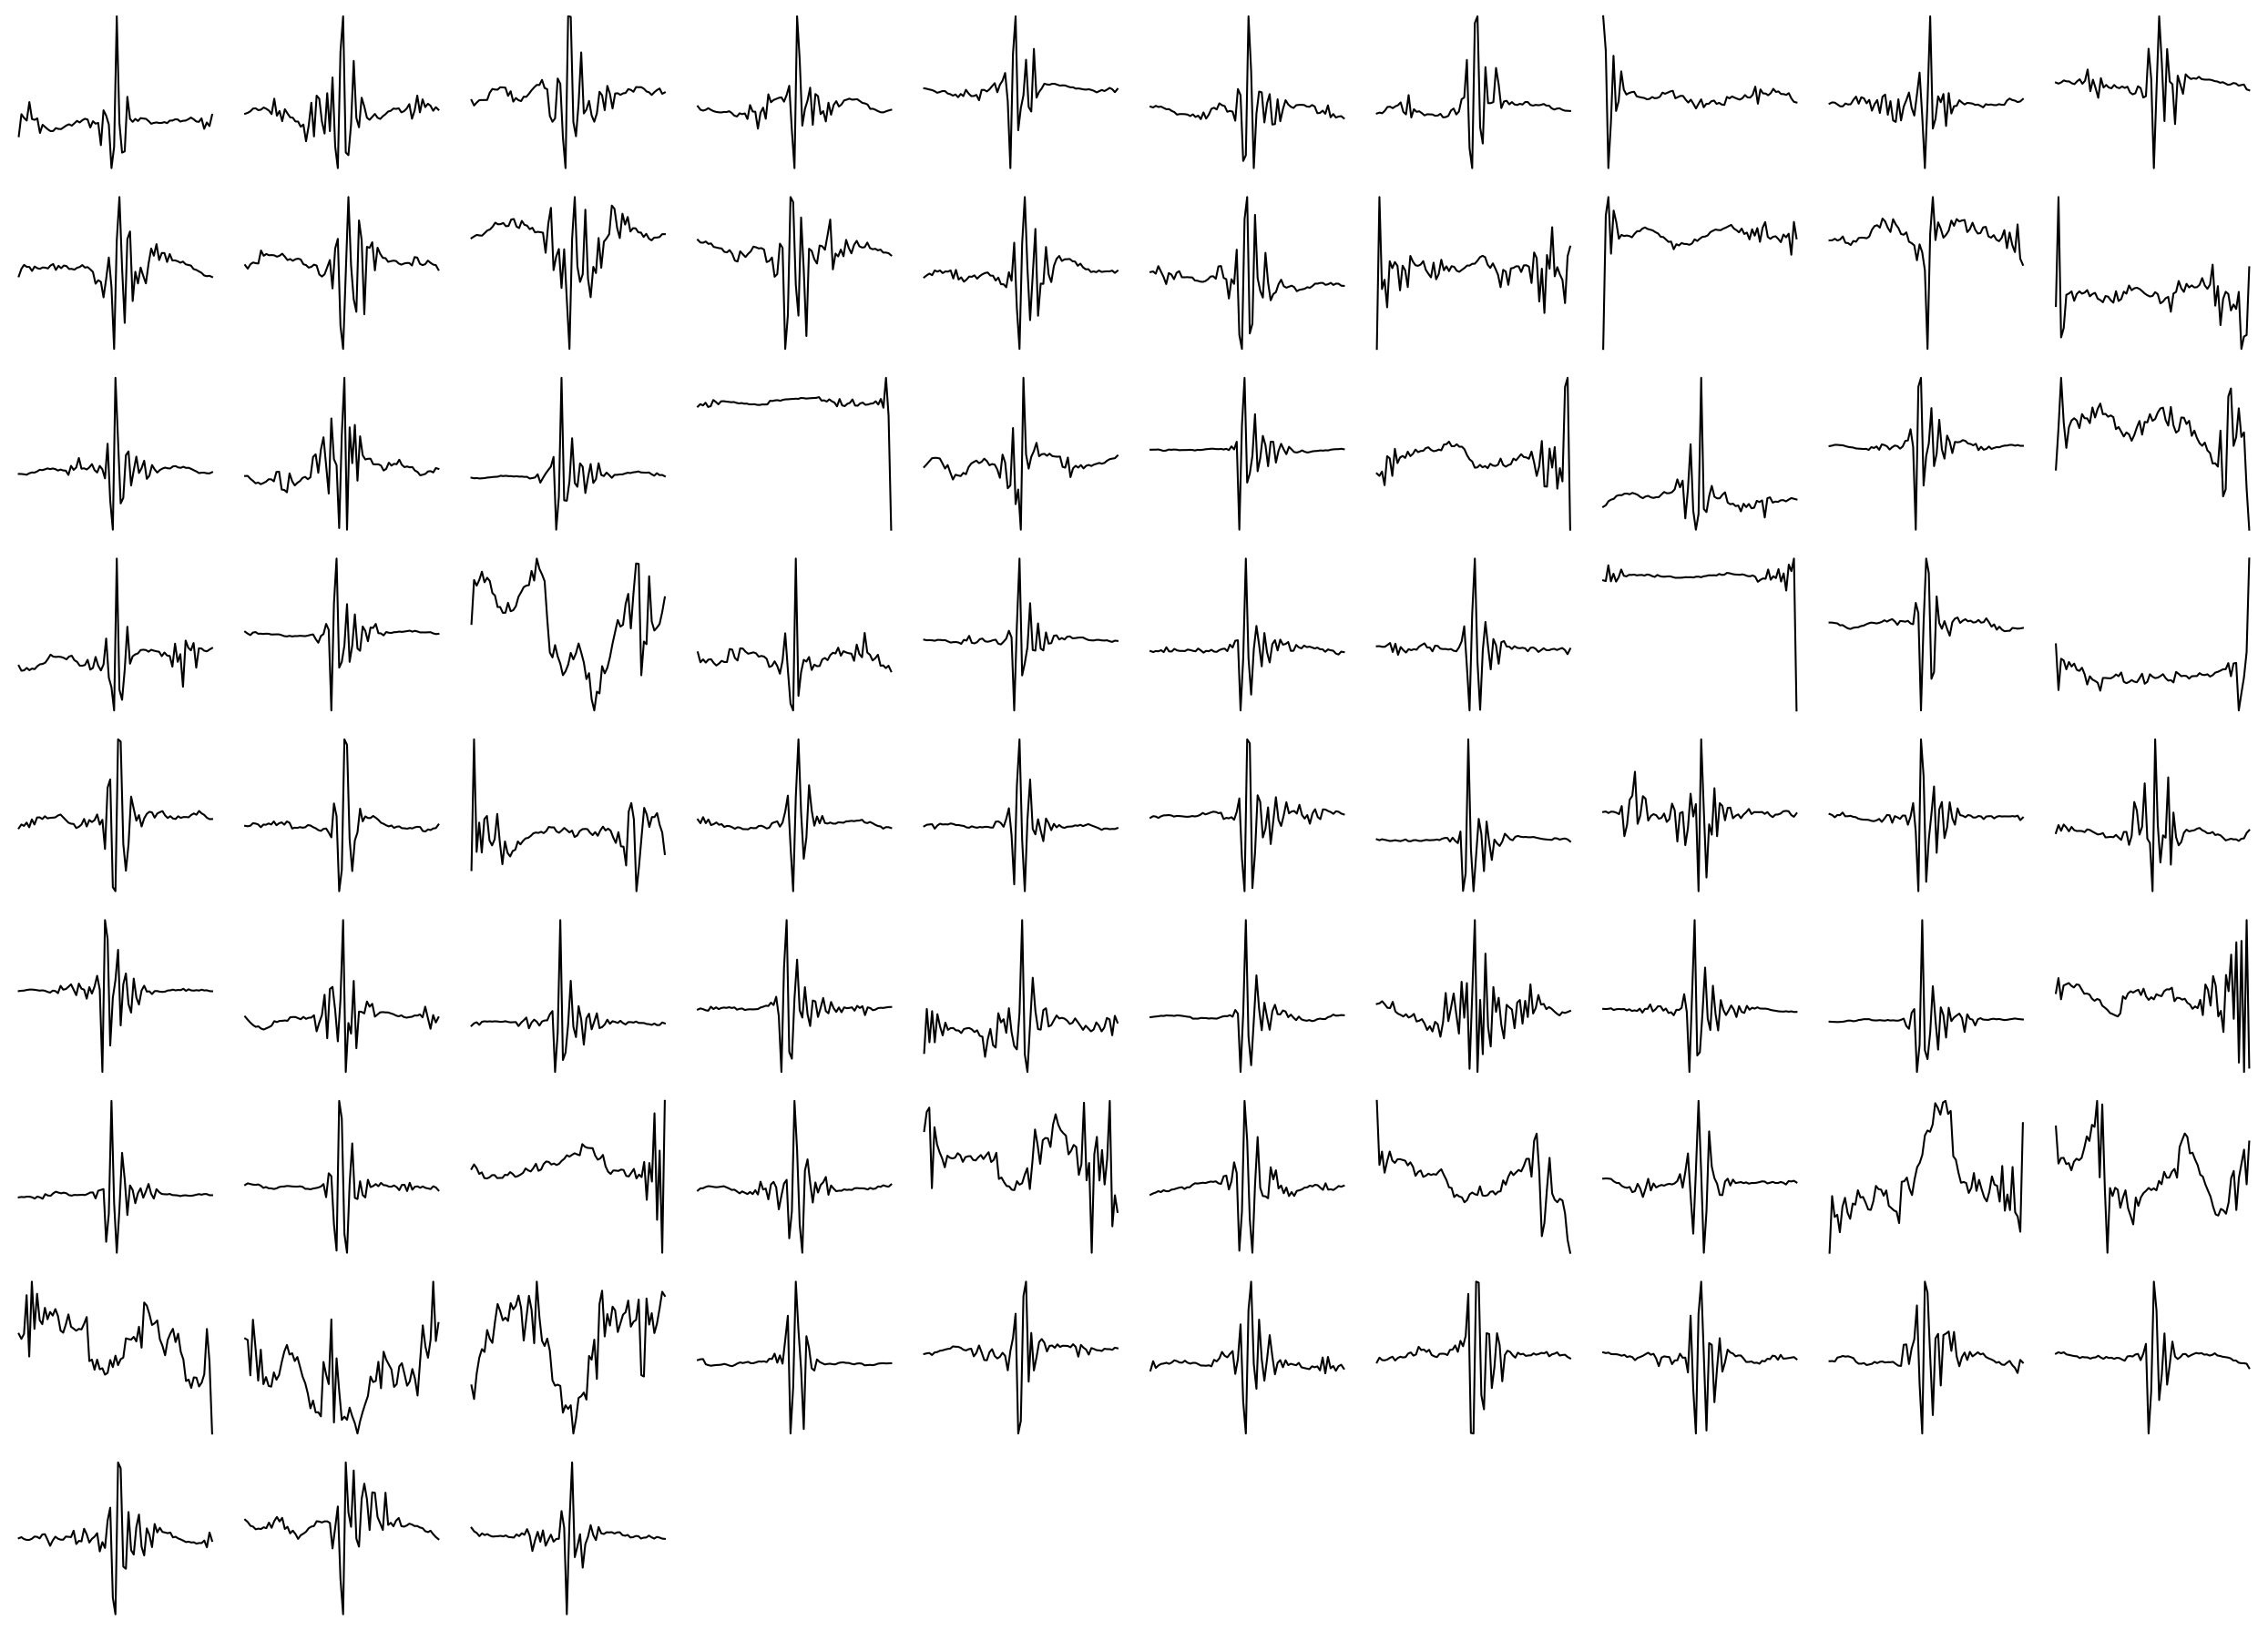

In [59]:
import matplotlib.pyplot as plt
import math

# Define the grid size
grid_size = int(math.ceil(math.sqrt(len(jth))))

# Create a figure and axis objects
fig, axs = plt.subplots(grid_size, grid_size, figsize=(25, 20))

# Iterate over each clic and its cluster label
for ii in range(len(jth)):
    # Calculate the row and column index in the grid
    row = ii // grid_size
    col = ii % grid_size
    
    # Plot the signal in the corresponding subplot with the color of its cluster
    axs[row, col].plot(Det[ii]['ss'], 'k', label='Original Signal')
    axs[row, col].axis('off')

# Remove empty subplots if the number of clic is not a perfect square
if len(jth) < grid_size ** 2:
    for i in range(len(jth), grid_size ** 2):
        row = i // grid_size
        col = i % grid_size
        fig.delaxes(axs[row, col])

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()

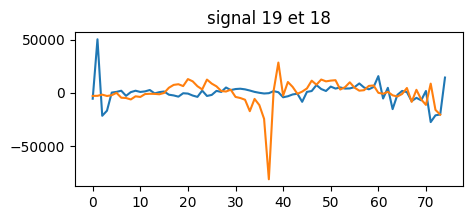

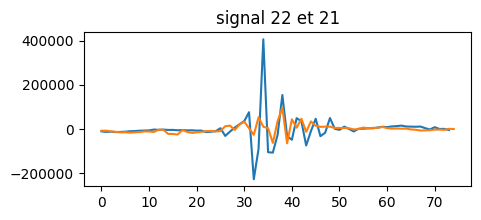

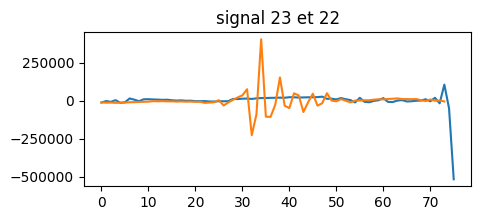

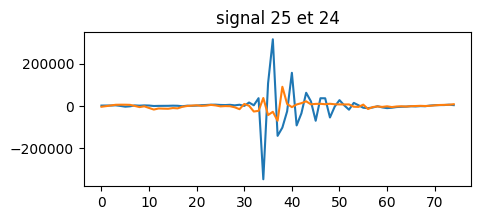

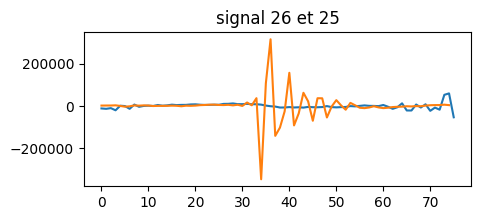

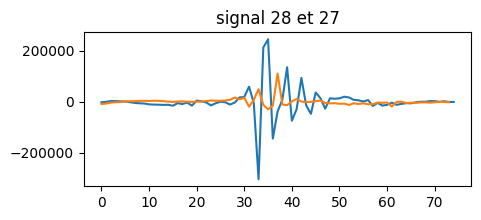

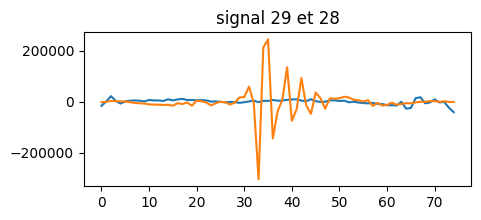

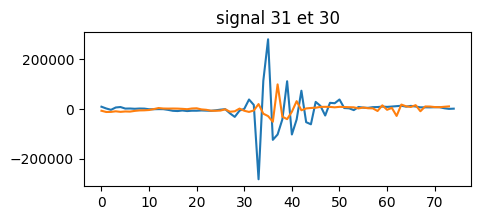

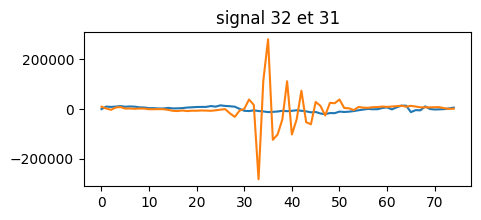

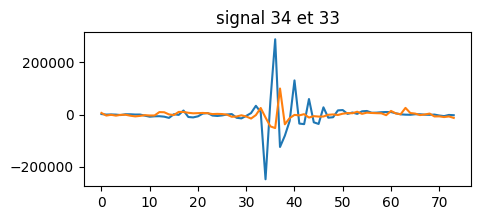

83 58


In [65]:
#ENLEVER LES ECHOS
import numpy as np

def est_echo(signal_original, signal_test, threshold=0.7):

    signal_original -= np.mean(signal_original)
    signal_test -= np.mean(signal_test)

    correlation_values = max(np.correlate(signal_original, - signal_test, mode='full'))
    correlation_values /= np.sqrt(np.sum(signal_original**2) * np.sum(signal_test**2))
    return np.max(signal_original) < -np.min(signal_original) and correlation_values > threshold


signal0 = Det[0]['ss']
avant = True
clic_echo_removed = [signal0]
indices_clic = [ Det[ii]['tdet']  for ii in range(len(Det))]
indices_clic_removed = [(indices_clic[0],(indices_clic[0]+len(signal0)/fs))]
k = 0
for ii in range(1, len(Det)):
    signal = Det[ii]['ss']
    if (not est_echo(signal0, signal, threshold=0.7) and (indices_clic[ii] - indices_clic[ii-1] > 0.08)) or avant:
        clic_echo_removed.append(signal)
        indices_clic_removed.append((indices_clic[ii],indices_clic[ii]+len(signal)/fs))
        avant = False

    else :
        avant = True
        if np.max(signal) > np.max(signal0):
            clic_echo_removed[-1] = signal
            avant = False
            indices_clic_removed[-1] = (indices_clic[ii],indices_clic[ii]+len(signal)/fs)
        if k <10 :
            plt.figure(figsize=(5, 2))
            plt.plot(signal)
            plt.plot(signal0)
            plt.title(f"signal {ii} et {ii-1}")
            plt.show()
        k+=1
    signal0 = signal
    

print(len(jth), len(clic_echo_removed))
plt.show()

In [66]:
#CALCUL CORRELATION NORMALIZEE
def correlation_normalized(signal1, signal2):
    correlation = np.max(np.correlate(signal1, signal2, mode='full'))
    return correlation

corr = []
num_signals = len(clic_echo_removed)
corr = np.zeros((num_signals, num_signals))

for i,clic in enumerate(clic_echo_removed):
    for j,clic2 in enumerate(clic_echo_removed):
            corr[i][j] = correlation_normalized(clic, clic2)

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# NOMBRE DE CLUSTER : ELBOW METHODE

# Define the range of possible cluster numbers
k_values = range(1, 15)

# Initialize an empty list to store the WCSS values
wcss_values = []

# Iterate over each value of k
for k in k_values:
    # Create a KMeans object with the current number of clusters
    kmeans = KMeans(n_clusters=k)
    
    # Fit the KMeans model to the data
    kmeans.fit(corr)
    
    # Calculate the WCSS value for the current number of clusters
    wcss = kmeans.inertia_
    
    # Append the WCSS value to the list
    wcss_values.append(wcss)

import numpy as np
from scipy.signal import find_peaks

# Calcul de la deuxième dérivée
second_derivative = np.diff(np.diff(wcss_values))

# Trouver les pics dans la deuxième dérivée (points de coude potentiels)
peaks, _ = find_peaks(-second_derivative)

# Choisir le point de coude comme le premier pic
elbow_index = peaks[0]

# Afficher l'abscisse du coude
elbow_x = elbow_index  # Ajouter 1 pour compenser la différence de longueur après les différenciations
print(f"L'abscisse du coude est : {elbow_x}")

# Calculate the difference between WCSS values at elbow_x and elbow_x + 1
diff = wcss_values[elbow_x] - wcss_values[elbow_x + 1]

# Calculate the total variation in the WCSS values
total_variation = max(wcss_values) - min(wcss_values)

# Calculate the confidence measure
confidence = diff / total_variation

print(f"The confidence in the prediction of elbow_x is: {confidence}")


c:\miniconda\envs\pynum\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\miniconda\envs\pynum\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\miniconda\envs\pynum\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\miniconda\envs\pynum\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\miniconda\envs\pynum\lib\site-packages\sklearn\cluster\_k

L'abscisse du coude est : 4
The confidence in the prediction of elbow_x is: 0.014863342656460101


In [68]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import math

# KMEANS FINAL

nombre_cluster = elbow_x+1
#clic_echo_removed_array = np.array(clic_echo_removed)

# Create a KMeans object with the desired number of clusters
kmeans = KMeans(n_clusters=nombre_cluster)

# Fit the KMeans model to the data
kmeans.fit(corr)

# Get the cluster labels for each data point
cluster_labels = kmeans.labels_

c:\miniconda\envs\pynum\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[(47.61270833333333, 47.613479166666664), (47.968625, 47.96939583333334), (48.10916666666667, 48.10994791666667), (48.201197916666665, 48.20197916666667), (48.30583333333333, 48.306614583333335), (48.40475, 48.405520833333334), (48.51388541666667, 48.51465625), (48.635, 48.63579166666666), (48.765166666666666, 48.7659375), (48.95582291666667, 48.95659375), (49.08922916666667, 49.09), (49.5385, 49.53927083333333), (49.654864583333335, 49.65563541666667), (49.88847916666667, 49.889250000000004), (50.00545833333333, 50.006229166666664), (50.13002083333333, 50.130802083333336), (51.65764583333333, 51.6584375), (51.78834375, 51.789125000000006), (51.9810625, 51.98184375), (54.47595833333333, 54.476739583333334), (54.59133333333333, 54.592104166666665), (54.74272916666666, 54.743510416666666), (54.884135416666666, 54.88491666666667), (54.998677083333334, 54.99945833333334), (55.10520833333333, 55.105979166666664), (55.2184375, 55.219208333333334), (55.32186458333333, 55.322635416666664), (55

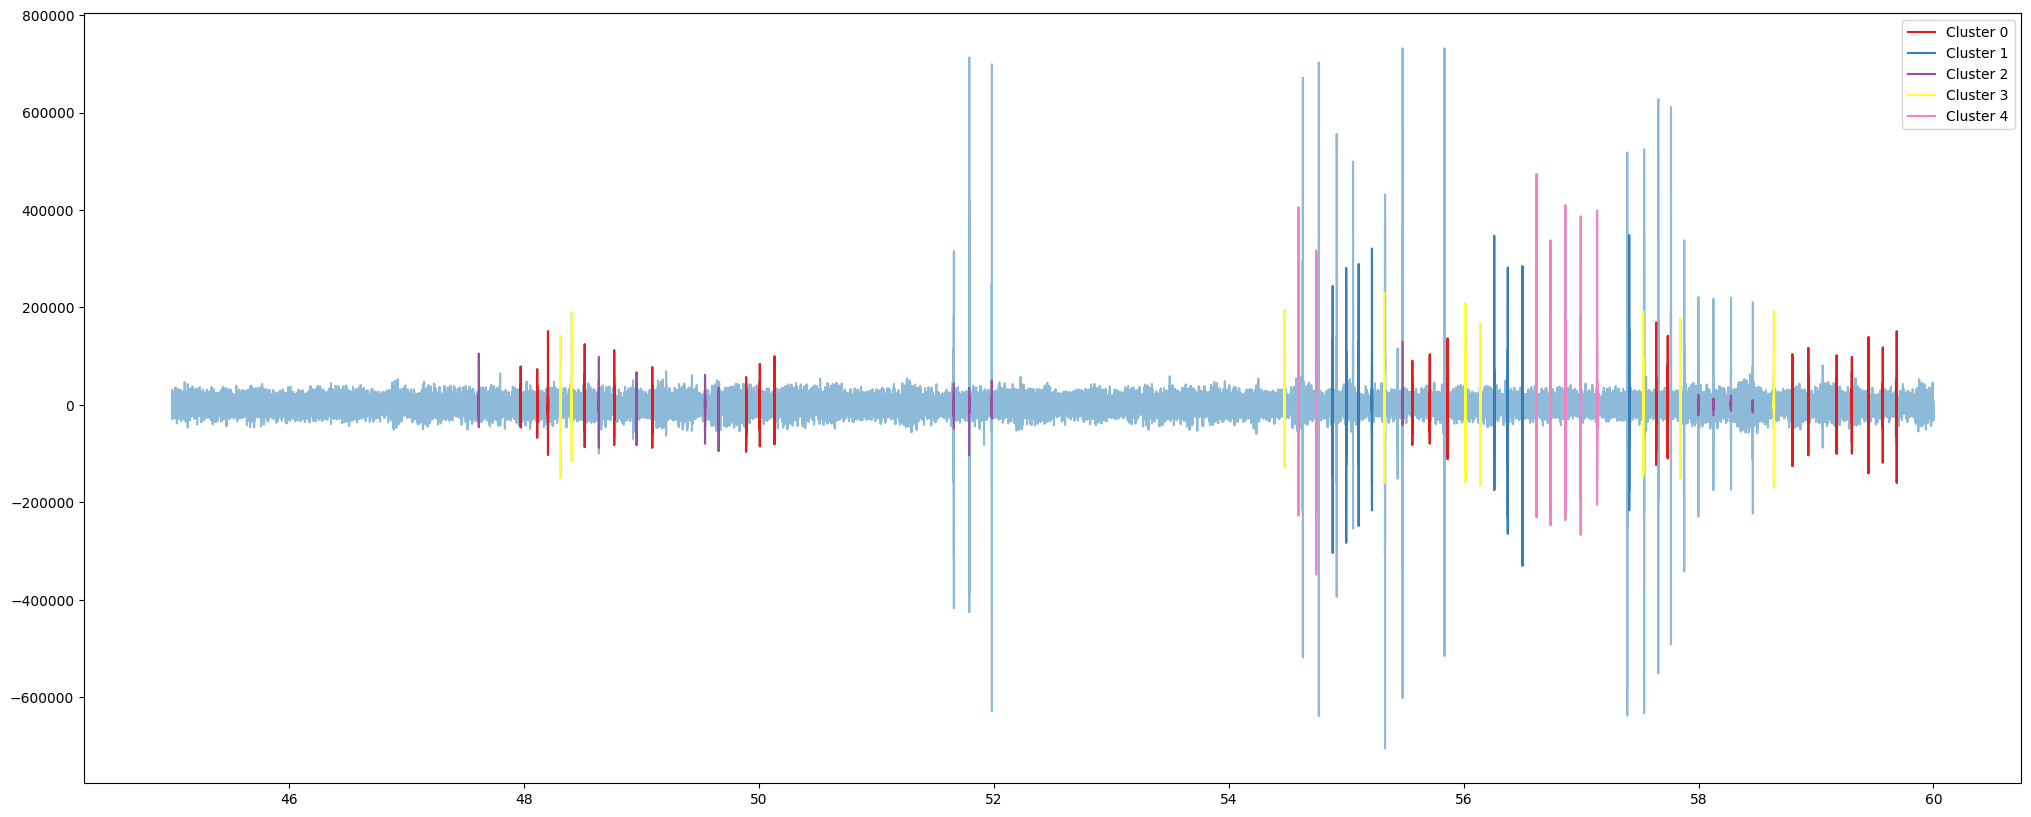

In [69]:
# Plot the signal y
plt.figure(figsize=(25, 10))
plt.plot(tt,ss,alpha=0.5)

# Initialize a set to keep track of the cluster labels
legend_labels = set()
print(indices_clic_removed)
# Iterate over each click and its cluster label
for i, (click, label) in enumerate(zip(clic_echo_removed, cluster_labels)):
    # Plot the click with a color based on its cluster label
    click = clic_echo_removed[i]
    a = indices_clic_removed[i][0]
    plt.plot(a + np.arange(len(click)) / fs , click, color=plt.cm.Set1(label / nombre_cluster))
    # Add the cluster label to the set
    legend_labels.add(label)

# Add legend for each unique cluster label
for label in legend_labels:
    plt.plot([], [], color=plt.cm.Set1(label / nombre_cluster), label=f'Cluster {label}')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [75]:
import numpy as np
import matplotlib.pyplot as plt


def generer_pistes(indices, ss):

    pistes = [[(indices[0])]]
    print(0)
    for i, (debut, fin) in enumerate(indices[1:]):
        piste_trouvee = False
        i+=1
        print(i)
        ICI_proche = []
        corr = []
        
        for j, piste in enumerate(pistes) :
            precedent = piste[-1]
            clic_avant = ss[int(fs*precedent[0]):int(fs*precedent[1])]
            print(clic_avant)
            clic_apres = ss[int(fs*debut):int(fs*fin)]
            amplitude_avant = np.max(clic_avant) - np.min(clic_avant)
            amplitude_apres = np.max(clic_apres) - np.min(clic_apres)
            delta_t = (debut - piste[-1][0])/fs

            if len(piste) > 1 :
                delta_t_1 = (piste[-1][0] - piste[-2][0])/fs
                
                if delta_t_1 * 0.8 < delta_t < delta_t_1 * 1/0.8 and amplitude_avant* 1/2 < amplitude_apres < amplitude_avant * 2 :
                    ICI_proche.append([j,abs(delta_t-delta_t_1)])

            else :
                fft_avant = np.fft.fft(clic_avant)
                fft_apres = np.fft.fft(clic_apres)
                if np.max(np.correlate(fft_avant, fft_apres,mode = 'full')) > 0.8 :
                    corr.append([j,np.max(abs(np.correlate(fft_avant, fft_apres,mode = 'same')))])

        if len(ICI_proche) > 0 :
            piste_trouvee = True
            ICI_proche = np.array(ICI_proche)
            indice_liste = int(ICI_proche[np.argmin(ICI_proche[:,1])][0])
            pistes[indice_liste].append((debut, fin))
            print(f"clic {i} va dans piste {indice_liste}, par ICI")
        
        elif len(corr) > 0 and len(ICI_proche)==0 :
            corr = np.array(corr)
            indice_liste = int(corr[np.argmax(corr[:,1])][0])
            pistes[indice_liste].append((debut, fin))
            print(f"clic {i} va dans piste {indice_liste}, par correlation")
            piste_trouvee = True

        elif not piste_trouvee:
            pistes.append([(debut, fin)])
            print(f"nouvelle piste crée, {len(pistes)-1}")

        #if (i + 1) % nscan == 0:
            #pistes = mise_a_jour_pistes(pistes, seuil)

    return pistes

In [76]:
# Simulation des résultats du tracker
resultats_tracker = generer_pistes(indices_clic_removed, ss)
print(len(resultats_tracker))

0
1
[]


ValueError: zero-size array to reduction operation maximum which has no identity

NameError: name 'resultats_tracker' is not defined

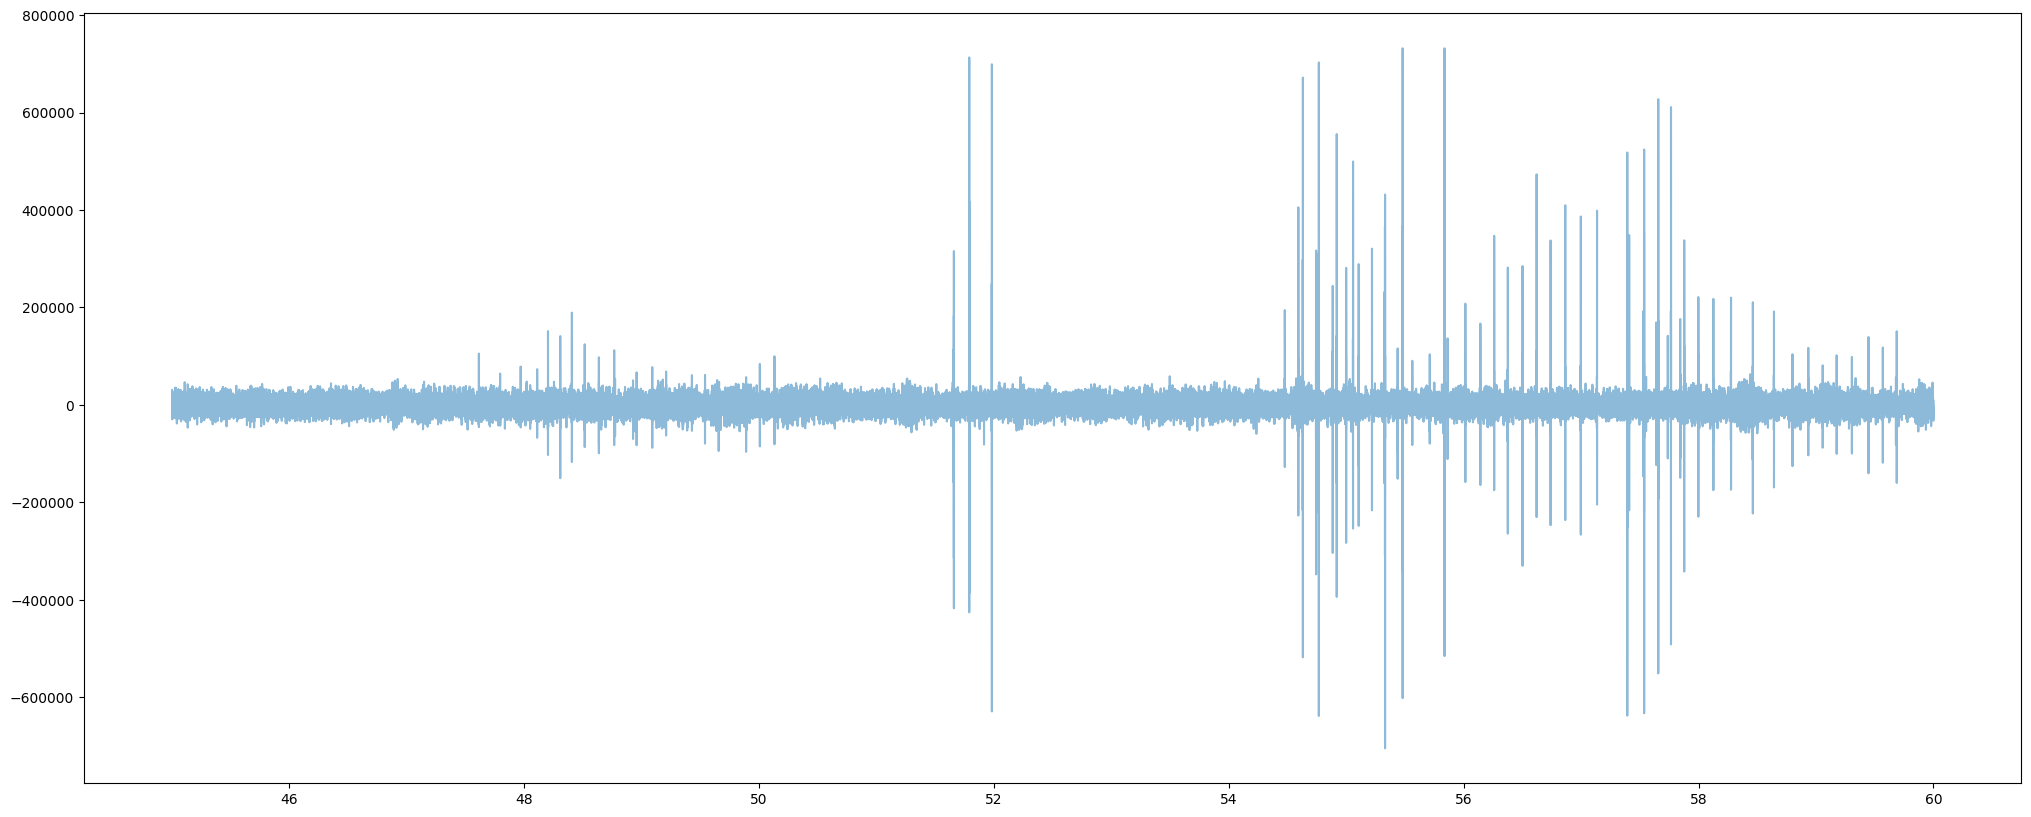

In [72]:
import random

# Plot the signal y
plt.figure(figsize=(25, 10))
plt.plot(tt, ss,alpha = 0.5)

# Initialize a set to keep track of the cluster labels
legend_labels = set()
resultats_tracker = [piste for piste in resultats_tracker if len(piste) > 2]
couleurs = ['#%06x' % random.randint(0, 0xFFFFFF) for _ in range(len(resultats_tracker))]

# Iterate over each click and its cluster label
for i, piste in enumerate(resultats_tracker):
    for j, (debut, fin) in enumerate(piste):
        # Plot the click with a color based on its cluster label
        plt.plot(np.linspace(debut, fin, len(ss[int(debut*fs):int(fin*fs)])), ss[int(debut*fs):int(fin*fs)],
                 color=couleurs[i])
    legend_labels.add(i)

# Add legend for each unique cluster label
for i,label in enumerate(legend_labels):
    plt.plot([], [], color=couleurs[i], label=f'Piste {label}')

# Add legend
plt.legend(loc='best', ncol=5)
plt.xlabel('Time [s]')
plt.ylabel('Pressure [Pa]')

# Show the plot
plt.show()

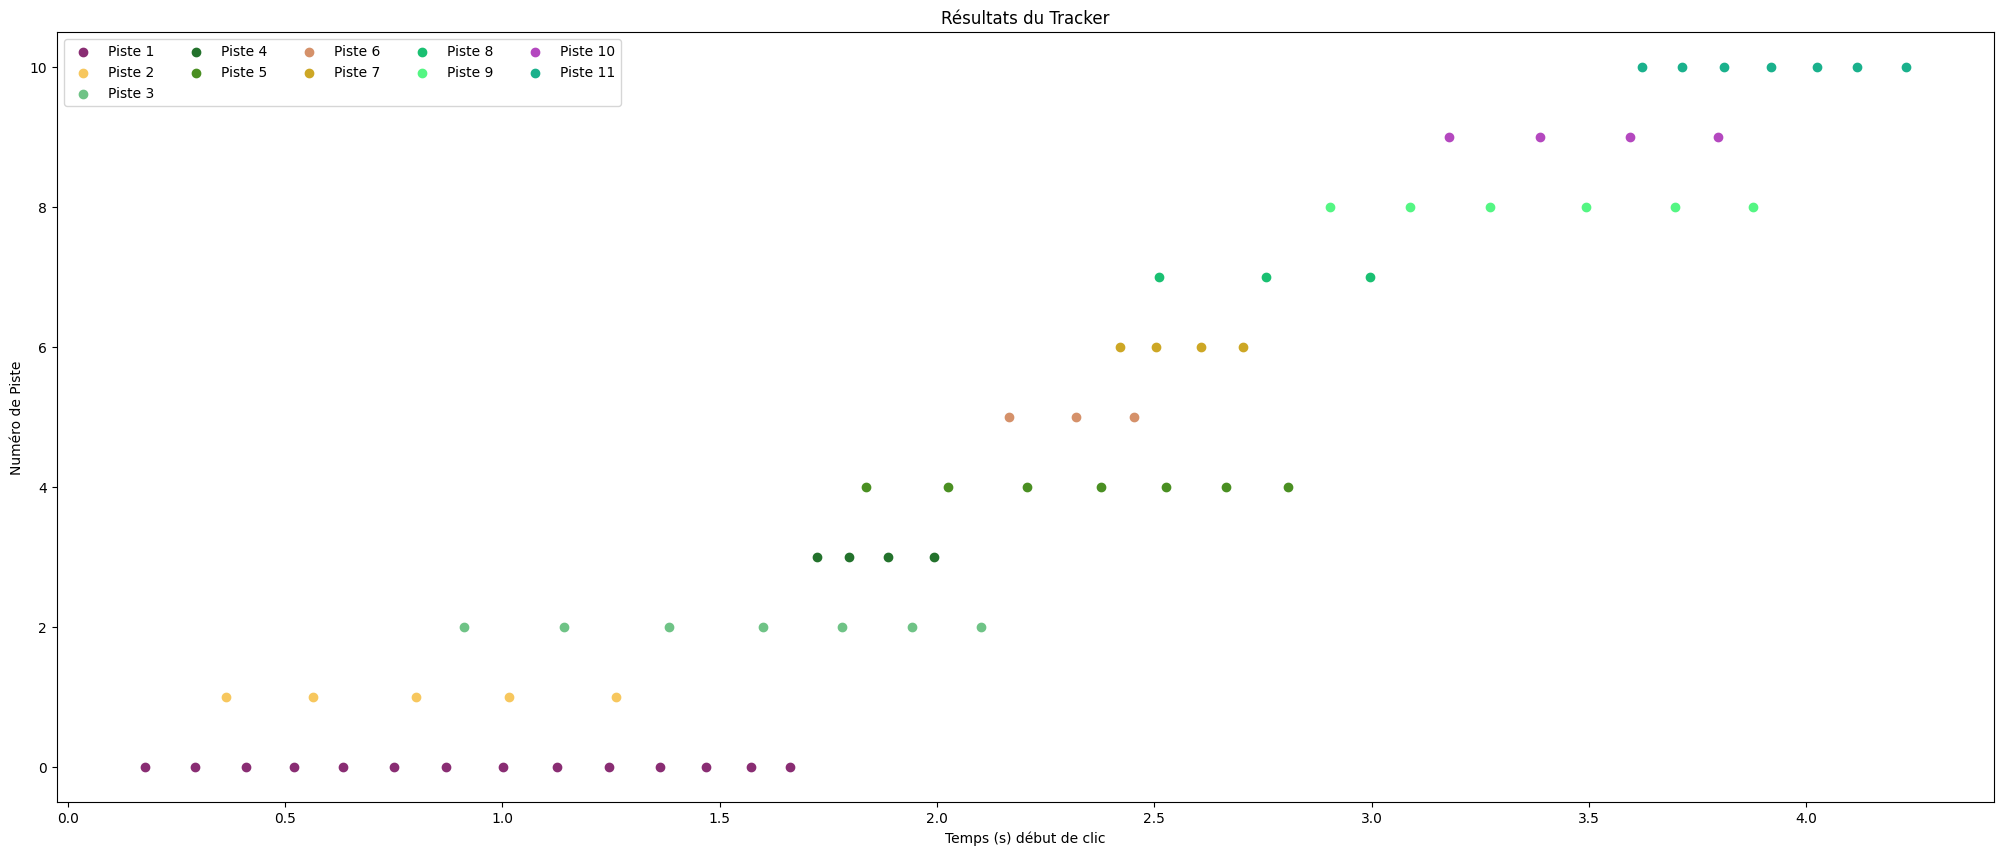

In [ ]:
# Visualisation des résultats du tracker
plt.figure(figsize=(25,10))
for i, piste in enumerate(resultats_tracker):
    plt.scatter([c[0] for c in piste], [i] * len(piste), marker='o',color = couleurs[i], label=f'Piste {i+1}')

plt.title('Résultats du Tracker')
plt.xlabel('Temps (s) début de clic')
plt.ylabel('Numéro de Piste')
plt.legend(loc='best', ncol=5)
plt.show()